In [ ]:
import tensorflow as tf
import os
import pickle
import pandas as pd
import numpy as np

def get_testing_data(directory,min_length,window_size):
    X = []
    y = []
    n = 60//window_size
    for f in os.listdir(directory):
        if f[0]=='.':
            continue
        data = pickle.load(open(directory+f,'rb'))
        if data.shape[0]//n<min_length:
            continue
        X.append(np.concatenate(list(data['data'])))
        y.extend([f]*data.shape[0])
    return np.concatenate(X),np.array(y)



def get_test_results_alll(window_size=20,activity='sports',n_user=50,min_length=100):
    data_directory = './data/'+str(window_size)+'/'+activity+'/testing/'
    model_directory = './models/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
    train_lengths = os.listdir(model_directory)
    X,y = get_testing_data(data_directory,min_length,window_size)
    save_directory = './predictions/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
    result_directory = './results/'
    if not os.path.isdir(save_directory):
        os.makedirs(save_directory)

    X.shape,y.shape

    from sklearn.metrics import accuracy_score
    def get_dictfilename(a):
        a = a.replace('trainedmodel','userdict').replace('hdf5','p')
        return a

    def get_predictions(df):
        indexes = np.array(list(df['index']))
        y_pred = model.predict(X[indexes])
        df['y_prob'] = list(y_pred)
        df['y_pred'] = y_pred.argmax(axis=1)
        return df


    for f in list(os.listdir(model_directory)):
        if f in os.listdir(save_directory) or f[0]=='.':
            continue
        print(f)
        model_files = [model_directory+f+'/'+a for a in os.listdir(model_directory+f) if a[-1]=='5']
        dict_files = [get_dictfilename(a) for a in model_files]
        pairs = list(zip(model_files,dict_files))
        predictions_all = []
        for i,a in enumerate(pairs):
            print(i,end=',')
            m_name,d_name = a
            user_dict = pickle.load(open(d_name,'rb'))
            indexes = np.array([i for i in range(len(y)) if y[i] in user_dict.keys()])
            y_temp = y[indexes]
            X_temp = X[indexes]
            y_final = np.array([user_dict[a] for a in y_temp])
            index_df = pd.DataFrame({'user':y_temp,'y':y_final,'index':np.arange(len(y_temp))})
            model = tf.keras.models.load_model(m_name)
            predictions = index_df.groupby('user',as_index=False).apply(get_predictions)
            predictions['iteration'] = i
            predictions_all.append(predictions)
        predictions_all = pd.concat(predictions_all)
        pickle.dump(predictions_all,open(save_directory+f,'wb'))
        print(f,'done')


    from sklearn.metrics import accuracy_score
    from scipy.stats import mode

    def get_results(df):
        df['y_prob'] = df['y_prob'].apply(lambda a:a.reshape(1,-1))
        rows = []
        rows.append([0,accuracy_score(df['y'],df['y_pred']),accuracy_score(df['y'],df['y_pred']),np.int64(f),df['user'].values[0],df['iteration'].values[0]])
        for t in test_lengths:
            y_true = []
            y_pred = []
            y_pred_maxmean = []
            for j in range(n_iter):
                n = t*3
                if n>df.shape[0]:
                    continue
                temp_df = df.sample(n,replace=False)
                y_true.append(temp_df['y'].values[0])
                y_pred.append(mode(temp_df['y_pred'])[0][0])
                y_pred_maxmean.append(np.concatenate(list(temp_df['y_prob'])).mean(axis=0).argmax())
            rows.append([t,accuracy_score(y_true,y_pred),accuracy_score(y_true,y_pred_maxmean),np.int64(f),df['user'].values[0],df['iteration'].values[0]])
        return pd.DataFrame(rows,columns=['test_length','majority_score',
                                          'maxmean_score','train_length',
                                          'user','iteration'])


    import sys
    from joblib import Parallel,delayed
    # if activity in ['stationery','std5']:
    test_lengths = list(np.arange(1,10,1))+list(np.arange(10,130,10))+list(np.arange(150,750,50))
    # else:
    #     test_lengths = list(np.arange(1,10,1))+list(np.arange(10,60,5))
    n_iter = 100
    base_window_size = 20
    final_results = []
    train_lengths = []
    # if activity+'.p' in os.listdir(result_directory):
    #     df = pickle.load(open(result_directory+activity+'.p','rb'))
    #     final_results.append(df)
    #     train_lengths = [str(a) for a in df['train_length'].unique()]

    for f in os.listdir(save_directory):
        if f in train_lengths:
            continue
        print(f)
        dd = pickle.load(open(save_directory+f,'rb'))
        all_dfs = list(dd.groupby(['user','iteration'],as_index=False))
        all_results = Parallel(n_jobs=40,verbose=2)(delayed(get_results)(all_dfs[k][1]) for k in range(len(all_dfs)))
        results = pd.concat(all_results)
        final_results.append(results)
        pickle.dump(pd.concat(final_results),open(result_directory+activity+str(n_user)+'.p','wb'))
        print(f,'done')

    results = pickle.load(open(result_directory+activity+str(n_user)+'.p','rb'))

    final_results = results.groupby(['test_length','iteration','train_length'],as_index=False).mean().groupby(['test_length','train_length'],as_index=False).mean()

    import seaborn as sns

    import matplotlib.pyplot as plt

    plt.rcParams.update({'font.size':40})
    plt.figure(figsize=(30,20))
    sns.lineplot(x='test_length',y='majority_score',hue='train_length',data=final_results)
    plt.ylim([0,1])
    plt.show()
    plt.rcParams.update({'font.size':40})
    plt.figure(figsize=(30,20))
    sns.lineplot(x='test_length',y='maxmean_score',hue='train_length',data=final_results)
    plt.ylim([0,1])
    plt.show()
    def save_data_final(extra=''):
        final_result_directory = './final_results/'
        activity1 = activity
        if activity=='std':
            activity1 += '20'
        activity1+=extra
        maxmean = pd.pivot_table(final_results,columns='train_length',index='test_length',values='maxmean_score',aggfunc='mean')
        maxmean.to_csv(final_result_directory+activity1+'_maxmean.csv')
        majority = pd.pivot_table(final_results,columns='train_length',index='test_length',values='majority_score',aggfunc='mean')
        majority.to_csv(final_result_directory+activity1+'_majority.csv')

    save_data_final('_'+str(n_user))
    return

In [ ]:
# for n_user in np.arange(50,350,50):
for n_user in [10,20,40]:
    get_test_results_alll(window_size=20,activity='sports',n_user=n_user,min_length=100)

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
directory = './results/'
activity = 'sports'
n_users = list(np.arange(50,350,50))+[10,20,40]

/cerebralcortex/kessel_jupyter_virtualenv/tensorflow/lib/python3.7/site-packages/pandas-1.2.3-py3.7-linux-x86_64.egg/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


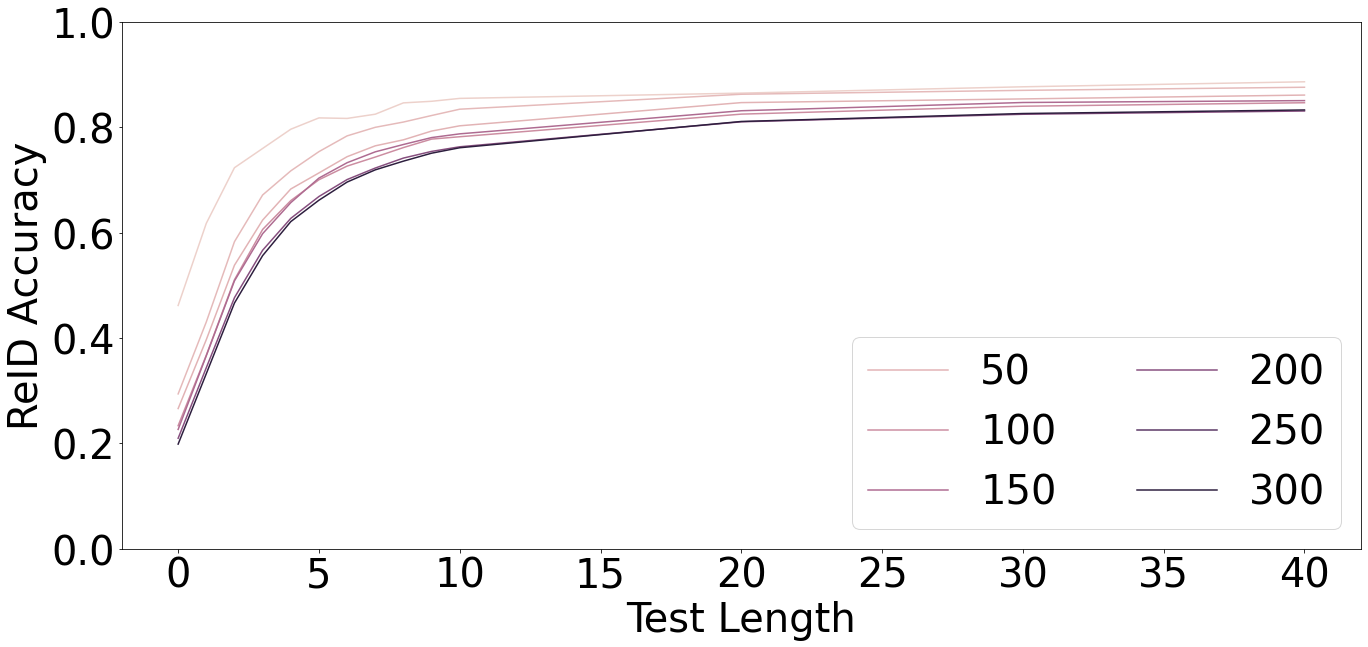

,,n_user,train_length,test_length,majority_score,maxmean_score,iteration,No. of Users
0,0,10,300,6,0.809000,0.816500,0.5,10
1,0,40,300,20,0.834625,0.862375,0.5,40
2,0,50,300,20,0.812900,0.846500,0.5,50
3,0,100,300,30,0.814300,0.839650,0.5,100
4,0,150,300,30,0.821233,0.846700,0.5,150
5,0,200,300,40,0.811525,0.830550,0.5,200
6,0,300,300,40,0.811767,0.832567,0.5,300


In [22]:
all_dfs = []
for n in n_users:
    df = pickle.load(open(directory+activity+str(n)+'.p','rb'))
    df['n_user'] = n
    all_dfs.append(df)

df = pd.concat(all_dfs)

# df.train_length.unique()

train_length = 300

df = df[~df.n_user.isin([20,250])]
df_150 = df[df.train_length>=train_length]


df_150 = df_150[df_150.test_length<50]

import seaborn as sns
df_150 = df_150.groupby(['n_user','train_length','test_length'],as_index=False).mean()

df_150['No. of Users'] = df_150['n_user']
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.lineplot(x='test_length',y='maxmean_score',hue='No. of Users',data=df_150)
plt.xlabel('Test Length')
plt.ylabel('ReID Accuracy')
plt.ylim([0,1])
plt.legend(ncol=2)
plt.tight_layout()
# plt.savefig('./images/sports_effect_of_activities.png')
plt.show()

df_150.to_csv('./images/sports_effect_of_activities.csv')

df_150 = df_150[df_150.majority_score>=.8]

def get_min_test(df):
    df = df.sort_values('test_length').reset_index(drop=True)
    return df[:1]
df1 = df_150.groupby(['n_user','train_length'],as_index=False).apply(get_min_test)

df1

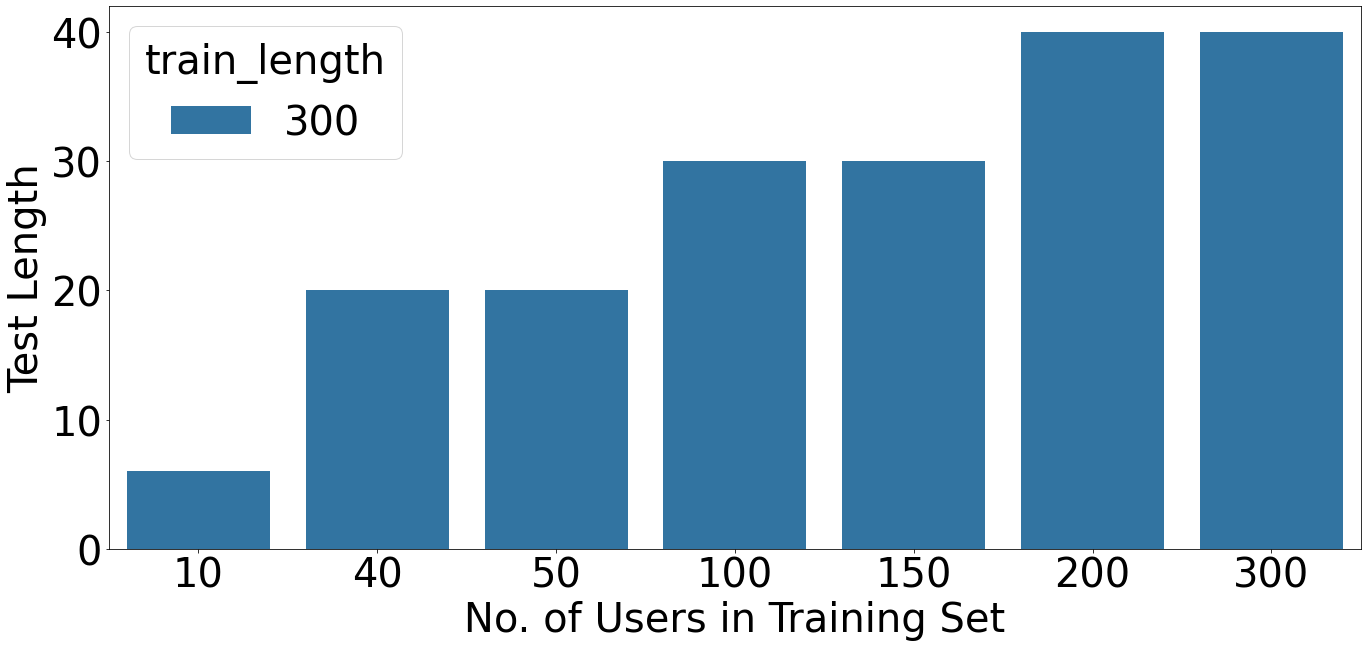

In [23]:
plt.rcParams.update({'font.size':40})
plt.figure(figsize=(20,10))
sns.barplot(x='n_user',y='test_length',hue='train_length',data=df1)
plt.xlabel('No. of Users in Training Set')
plt.ylabel('Test Length')
plt.tight_layout()
plt.savefig('non-periodic.png')
plt.show()